# Topic Modeling Discovery

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle 

# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# spacy
import spacy

# corex
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

from preprocessing_funcs import clean_tweet, get_hashtags, get_emojis

In [2]:
with open('../data_files/processed_tweets.pickle', 'rb') as read_file:
    tweets = pickle.load(read_file)

In [3]:
tweets.head()

,clean,processed
0,islam kills are you trying to say that there w...,islam kill try say terrorist attack europe ref...
1,clinton trump should ve apologized more attack...,clinton trump apologize attack little
2,who was is the best president of the past year...,well president past retweet
3,i don t have to guess your religion christmasa...,guess religion christmasaftermath
4,pence and his lawyers decided which of his off...,pence lawyer decide official email public can see


In [4]:
tweets.tail()

,clean,processed
203477,in intel circles the story goes fsb filmed tru...,intel circle story go fsb film trump orgy russ...
203478,tonganoxie police middle school girl sexually ...,tonganoxie police middle school girl sexually ...
203479,getting the right company logo how businesses ...,get right company logo business get message ac...
203480,the latest obama affirms continuity of ties wi...,late obama affirm continuity tie canada
203481,u cant just upload a cd online amp thats it wh...,u can not upload cd online product work u get ...


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203482 entries, 0 to 203481
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   clean      203482 non-null  object
 1   processed  203482 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [7]:
proc_tweets = tweets.processed

## KMeans

In [8]:
%%time

tfidfconvert = TfidfVectorizer(use_idf=True, smooth_idf=True, stop_words='english')
tweets_transformed = tfidfconvert.fit_transform(proc_tweets)

CPU times: user 1.83 s, sys: 43.7 ms, total: 1.88 s
Wall time: 1.88 s


In [9]:
%%time
inertias = []

for k_ in np.arange(1, 21):
    km = KMeans(n_clusters=k_)
    km.fit(tweets_transformed)
    inertias.append(km.inertia_)

CPU times: user 1h 4min 8s, sys: 1min 44s, total: 1h 5min 53s
Wall time: 8min 22s


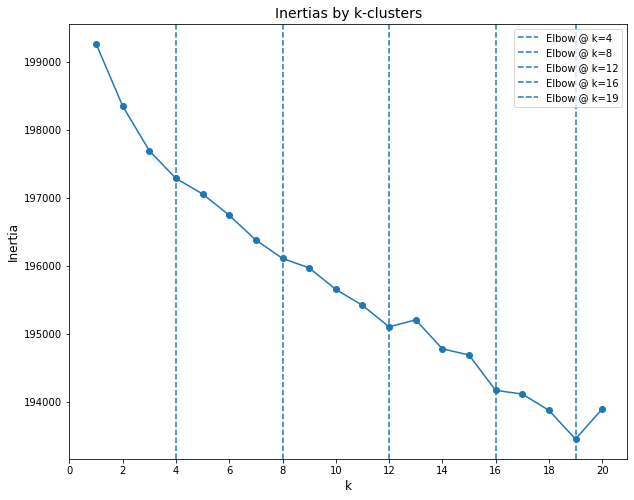

In [12]:
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.plot(np.arange(1, 21), inertias, marker='o')
plt.axvline(x=4, ls='--', label='Elbow @ k=4')
plt.axvline(x=8, ls='--', label='Elbow @ k=8')
plt.axvline(x=12, ls='--', label='Elbow @ k=12')
plt.axvline(x=16, ls='--', label='Elbow @ k=16')
plt.axvline(x=19, ls='--', label='Elbow @ k=19')
plt.xticks(np.arange(0, 22, step=2))
plt.title('Inertias by k-clusters', fontsize=14)
plt.ylabel("Inertia", fontsize=12)
plt.xlabel('k', fontsize=12)
plt.legend();

## Topic Modeling

In [13]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### LSA

Will start with 10 topics - the most pronounced first elbow from above.

In [20]:
vectorizer = TfidfVectorizer(use_idf=True, 
                             smooth_idf=True,
                             stop_words='english')

svd_model = TruncatedSVD(n_components=8, 
                         algorithm='randomized',
                         n_iter=100,
                         random_state=42)

# pipeline of vectorizer, model fit and applied to docs: 

svd_transformer = Pipeline([('tfidf', vectorizer),
                           ('svd', svd_model)])

svd_matrix = svd_transformer.fit_transform(proc_tweets)

# Display
terms = vectorizer.get_feature_names()
display_topics(svd_model, terms, 10)


Topic  0
trump, donald, hillary, clinton, real, president, say, politic, obama, people

Topic  1
hillary, clinton, email, campaign, obama, lie, politic, foundation, fbi, say

Topic  2
people, obama, like, say, make, know, good, want, love, thing

Topic  3
president, obama, trump, say, politic, news, election, new, michelle, barack

Topic  4
say, politic, trump, clinton, debate, news, thing, know, campaign, poll

Topic  5
obama, real, donald, say, tcot, islam, pjnet, kill, america, stop

Topic  6
make, love, america, great, good, day, know, time, let, god

Topic  7
love, president, people, hillary, say, islam, kill, want, stop, real


Try again with CountVectorizer

In [19]:
vectorizer = CountVectorizer(token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True, 
                             stop_words='english')

svd_model = TruncatedSVD(n_components=8, 
                         algorithm='randomized',
                         n_iter=100,
                         random_state=42)

# pipeline of tf-idf + SVD, fit and applied to docs: 

svd_transformer = Pipeline([('cv', vectorizer),
                           ('svd', svd_model)])

svd_matrix = svd_transformer.fit_transform(proc_tweets)


terms = vectorizer.get_feature_names()
display_topics(svd_model, terms, 10)


Topic  0
trump, donald, hillary, clinton, real, say, president, obama, politic, people

Topic  1
clinton, hillary, obama, email, campaign, say, fbi, foundation, politic, lie

Topic  2
obama, say, people, like, make, president, tcot, news, pjnet, want

Topic  3
donald, real, obama, hillary, america, people, tcot, pjnet, maga, make

Topic  4
people, say, like, make, hillary, know, want, thing, think, good

Topic  5
clinton, say, donald, real, politic, new, news, email, foundation, fbi

Topic  6
say, hillary, donald, real, obama, russia, supporter, hack, benghazi, bomb

Topic  7
make, new, tcot, america, pjnet, great, ccot, news, day, time


### NMF

In [21]:
vectorizer = CountVectorizer(token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True, 
                             stop_words='english')

nmf_model = NMF(n_components=8)

# pipeline of tf-idf + SVD, fit and applied to docs: 

nfm_transformer = Pipeline([('cv', vectorizer),
                           ('nmf', nmf_model)])

nmf_matrix = nfm_transformer.fit_transform(proc_tweets)


terms = vectorizer.get_feature_names()
display_topics(nmf_model, terms, 10)


Topic  0
trump, president, politic, donald, supporter, maga, medium, poll, news, rally

Topic  1
hillary, lie, maga, want, know, debate, benghazi, woman, supporter, think

Topic  2
obama, president, news, tcot, barack, michelle, pjnet, isis, politic, american

Topic  3
donald, real, trump, america, maga, need, potus, thank, mike, trumptrain

Topic  4
people, like, thing, black, look, know, think, want, twitter, white

Topic  5
clinton, politic, email, campaign, foundation, fbi, poll, news, new, state

Topic  6
say, know, news, good, thing, woman, want, election, politic, man

Topic  7
make, new, america, tcot, pjnet, great, day, time, ccot, good


Pretty similar to LSA

### Corex

[lecture example notebook](https://github.com/scrapfishies/onl20_ds4/blob/master/curriculum/project-04/fancy-nlp/corex/CorEx.ipynb)

In [22]:
vectorizer = CountVectorizer(token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True,
                             stop_words='english')

doc_word = vectorizer.fit_transform(proc_tweets)
words = list(np.asarray(vectorizer.get_feature_names()))

In [23]:
topic_model = ct.Corex(n_hidden=8, 
                       words=words,
                       max_iter=200, 
                       seed=42)


topic_model.fit(doc_word, words=words, docs=proc_tweets)

In [24]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n, topic in enumerate(topics):
    topic_words, _ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: merkel, muss, ist, die, das, es, sie, ich, mit, den
1: clinton, hillary, email, campaign, fbi, politic, news, poll, dnc, wikileaks
2: trump, donald, real, president, maga, supporter, pence, rally, swamp, drain
3: tcot, pjnet, ccot, wakeupamerica, cruzcrew, teaparty, nra, tgdn, uniteblue, tlot
4: obama, gop, midnight, american, white, americans, cruz, black, law, illegal
5: islam, kill, refugee, muslim, terrorist, muslims, attack, islamic, isis, nation
6: alternativeacronyminterpretations, star, wear, abrams, jenn, ilove, butihate, girl, jones, kim
7: police, politician, gift, idea, shoot, school, officer, cop, student, man


These topics look more promising - much more diverse

In [26]:
# Let's check out topic : clinton
topic_model.get_top_docs(topic=1, n_docs=10)

[('break entire clinton campaign implicate dnc violence voter fraud scheme drain swamp',
  0.0),
 ('hacker release ton email clinton state department insider', 0.0),
 ('wikileaks arianna huffington co founder huffinton post prefer covert influence tcot ccot',
  0.0),
 ('new doc show clinton foundation donor seek access state department via',
  0.0),
 ('rep clinton aide get immunity deal direct email scrub via foxnews', 0.0),
 ('confirm clinton foundation also fbi investigation sundaymorning thisweek facethena',
  0.0),
 ('levinsurge call housegop member tell voteno ryancare yes expect cantored mar',
  0.0),
 ('gansler sachs call fbi decision clinton email serious mistake politic',
  0.0),
 ('wikileaks fbi agent push clinton foundation investigation justice dept sh tcot ccot',
  0.0),
 ('believe julian assange appear exclusive onrt russia today say russians nothing',
  0.0)]

Yikes

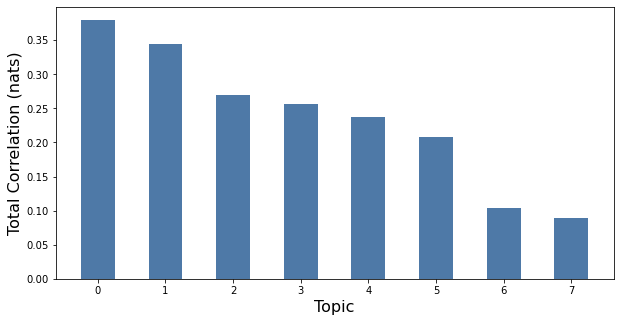

In [27]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [28]:
topic_model.tc

1.8896454714616562

Testing some anchors based on the topic results

In [29]:
topics = [['donald', 'trump', 'maga'],                                             # trump stuff
          ['hillary', 'clinton'],                                                  # hillary stuff
          ['merkel', 'muss', 'die', 'ist', 'ich', 'das'],                          # german stuff
          ['blacklivesmatter'],                                                    # BLM
          ['police', 'officer', 'shoot'],                                          # police stuff
          ['obama', 'barack'],                                                     # obama stuff
          ['isis', 'muslim', 'islam']                                              # isis/islam stuff
         ]

len(topics)

7

Will plot out 7 anchors and let CorEx decide a few more.

In [30]:
topic_model = ct.Corex(n_hidden=10, 
                       words=words,
                       max_iter=200, 
                       seed=42)

topic_model.fit(doc_word, words=words, docs=proc_tweets, 
                anchors=topics, anchor_strength=7)

In [31]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: trump, donald, maga, real, president, politic, supporter, poll, rally, trumptrain
1: clinton, hillary, email, campaign, foundation, fbi, wikileaks, debate, benghazi, crook
2: die, merkel, muss, ist, das, ich, sie, es, mit, den
3: blacklivesmatter, play, music, ft, gt, soundcloud, feat, black, artist, mixtape
4: police, shoot, officer, cop, suspect, san, arrest, dallas, man, brutality
5: obama, barack, michelle, administration, admin, legacy, hussein, malia, pres, veto
6: islam, isis, muslim, kill, brussels, refugee, opiceisis, iceisis, prayforbrussels, stop
7: tcot, gop, pjnet, news, midnight, ccot, cruz, election, democrat, state
8: favorite, headline, trumps, enlist, patriot, god, west, army, renewus, super
9: new, cnn, medium, york, oscarhasnocolor, msnbc, oscars, session, watch, assange


In [34]:
# Let's check out topic : graphics
topic_model.get_top_docs(topic=1, n_docs=10)

[('rudy giuliani hillary know call say one thing private one public call li',
  0.0),
 ('shalabh elect hillary mean end american civilization', 0.0),
 ('trump clinton representative attend brief transition', 0.0),
 ('monmouth u poll echo nbc wsj big clinton lead clinton trump', 0.0),
 ('internal poll show trump lead hillary believe medium', 0.0),
 ('husband bill clinton look woman decide want rape scale', 0.0),
 ('hillary clinton win election lose', 0.0),
 ('hillary clinton support radical increase syrian refugee come u maga', 0.0),
 ('joe biden surprise volunteer hillary clinton campaign cleveland politic',
  0.0),
 ('twitter censor real life bill clinton get heckle w rapist trend people ha',
  0.0)]

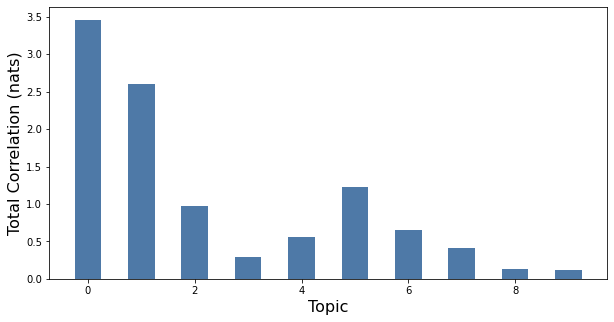

In [35]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [36]:
topic_model.tc

10.406523992892142

CorEx seems like it'll be useful in teasing out sub-topics using the anchors. I'll dig deeper into CorEx's topics in a separate notebook. 

### LDA